# Evaluations against the MNIST dataset

## Setup 

In [1]:
import sys

sys.path.append("../../src")


from alibi.explainers import Counterfactual, CounterfactualProto
from tuneable_counterfactuals_explainer.explainer import Explainer
from tuneable_counterfactuals_explainer.single_variable_explainer import (
    SingleVariableExplainer,
)
from scipy.ndimage import gaussian_filter
import shap

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.svm import SVR

import keras
import numpy as np
from keras import layers
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor

import shap

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import Pipeline

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterfactualProto

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-09 21:08:39,461	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Get MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Filter to only 0s and 1s
x_train = x_train[(y_train == 0) | (y_train == 1)]
y_train = y_train[(y_train == 0) | (y_train == 1)]
x_test = x_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]

# Reshape and normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Set Data Range
xmin, xmax = -0.5, 0.5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (
    xmax - xmin
) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (
    xmax - xmin
) + xmin


# Define Model
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=64, kernel_size=2, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x_out = Dense(2, activation="softmax")(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return cnn


clf = KerasRegressor(build_fn=cnn_model, epochs=5, batch_size=32, verbose=1)
sklearn_pipeline = Pipeline([("clf", clf)])
keras.utils.set_random_seed(0)
sklearn_pipeline.fit(x_train, y_train)

cnn = sklearn_pipeline[0].model

# Evaluate Model
score = cnn.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", score[1])

x_train shape: (60000, 28, 28) y_train shape: (60000,)
Train on 12665 samples
Epoch 1/5
   32/12665 [..............................] - ETA: 19s - loss: 0.6753 - acc: 0.5625

/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_29428/743119571.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(build_fn=cnn_model, epochs=5, batch_size=32, verbose=1)
2024-07-09 21:08:42.692393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-09 21:08:42.706774: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:477 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

12665/12665 [==============================] - 3s 216us/sample - loss: 0.0252 - acc: 0.9900
Epoch 2/5
12665/12665 [==============================] - 3s 219us/sample - loss: 0.0059 - acc: 0.9981
Epoch 3/5
12665/12665 [==============================] - 3s 220us/sample - loss: 0.0037 - acc: 0.9990
Epoch 4/5
12665/12665 [==============================] - 3s 212us/sample - loss: 0.0033 - acc: 0.9990
Epoch 5/5
12665/12665 [==============================] - 3s 222us/sample - loss: 0.0047 - acc: 0.9987
Test accuracy:  1.0


/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-07-09 21:08:56.533565: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:216 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [3]:
def predict_class(x):
    return cnn.predict(x).argmax(axis=1)[0]

## Baseline Methodology

In [4]:
cf_baseline = Counterfactual(
    cnn,
    shape=(1,) + x_train.shape[1:],
    feature_range=(-0.5, 0.5),
)

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-07-09 21:08:57.000081: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:140 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [5]:
res_baseline = cf_baseline.explain(x_train[0].reshape(1, 28, 28, 1))

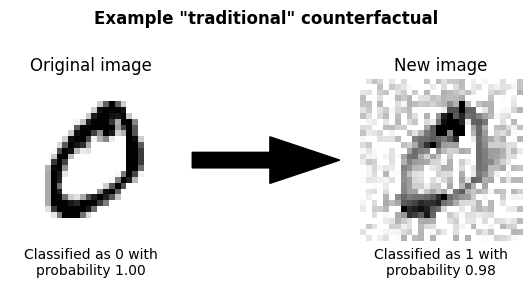

In [6]:
fig, axs = plt.subplots(1, 3)
plt.suptitle('Example "traditional" counterfactual', weight="bold")

# Plot the first image
axs[0].imshow(
    np.array(x_train[0]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0].set_title("Original image")
axs[0].set_xlabel(
    f"Classified as {predict_class(x_train[0].reshape(1, 28,28,1))} with\nprobability {cnn.predict(x_train[0].reshape(1, 28,28,1)).max():.2f}"
)

# Add an arrow between the two images
axs[1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
axs[1].set_ylim([0, 1])

# Plot the second image
final = res_baseline.cf["X"].reshape(28, 28)
axs[2].imshow(np.array(final).astype(np.float32).reshape(28, 28), cmap="binary")
axs[2].set_title(
    "New image",
)
axs[2].set_xlabel(
    f'Classified as {predict_class(res_baseline.cf["X"])} with\nprobability {cnn.predict(res_baseline.cf["X"]).max():.2f}'
)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_aspect("equal")

plt.tight_layout()
fig.subplots_adjust(top=1.3)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)
plt.savefig("../../figures/mnist_counterfactual_trad_example.eps", bbox_inches="tight")
plt.show()

## Prototype Methodology 

In [7]:
cf_prototype = CounterfactualProto(
    cnn,
    shape=(1,) + x_train.shape[1:],
    feature_range=(-0.5, 0.5),
)

In [8]:
# res_prototype = cf_prototype.explain(x_train[0].reshape(1, 28, 28, 1))

In [9]:
# fig, axs = plt.subplots(1, 3)
# plt.suptitle('Example "traditional" counterfactual', weight="bold")

# # Plot the first image
# axs[0].imshow(
#     np.array(x_train[0]).astype(np.float32).reshape(28, 28),
#     cmap="binary",
# )
# axs[0].set_title("Original image")
# axs[0].set_xlabel(
#     f"Classified as {predict_class(x_train[0].reshape(1, 28,28,1))} with\nprobability {cnn.predict(x_train[0].reshape(1, 28,28,1)).max():.2f}"
# )

# # Add an arrow between the two images
# axs[1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
# axs[1].set_ylim([0, 1])

# # Plot the second image
# final = res_prototype.cf["X"].reshape(28, 28)
# axs[2].imshow(np.array(final).astype(np.float32).reshape(28, 28), cmap="binary")
# axs[2].set_title(
#     "New image",
# )
# axs[2].set_xlabel(
#     f'Classified as {predict_class(res_prototype.cf["X"])} with\nprobability {cnn.predict(res_prototype.cf["X"]).max():.2f}'
# )


# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)
#     ax.set_aspect("equal")

# plt.tight_layout()
# fig.subplots_adjust(top=1.3)
# fig.subplots_adjust(right=0.9)
# fig.subplots_adjust(left=0.1)
# plt.savefig("../../figures/mnist_counterfactual_trad_example.eps", bbox_inches="tight")
# plt.show()

## Novel Counterfactuals

In [10]:
import copy

In [11]:
from sklearn.preprocessing import FunctionTransformer

In [12]:
pipeline_with_reshape = copy.copy(sklearn_pipeline)

In [13]:
pipeline_with_reshape.steps.insert(
    0, ("reshape", FunctionTransformer(lambda x: x.values.reshape(-1, 28, 28, 1)))
)

In [14]:
df = pd.DataFrame(x_train.reshape(-1, 28 * 28))
df.columns = [f"pixel_{i}" for i in range(28 * 28)]
df["target"] = y_train[:, 1]
pipeline_with_reshape[0].feature_names_in_ = df.columns[:-1]

In [15]:
pipeline_with_reshape.predict(df.iloc[0:10][df.columns[:-1]]).reshape(-1, 2)

array([[1.0000000e+00, 3.9144701e-10],
       [5.9192195e-07, 9.9999940e-01],
       [8.6375394e-07, 9.9999917e-01],
       [2.9759988e-06, 9.9999702e-01],
       [3.4793397e-06, 9.9999654e-01],
       [1.0000000e+00, 1.6984267e-09],
       [1.4823581e-06, 9.9999857e-01],
       [6.9145572e-05, 9.9993086e-01],
       [9.9999774e-01, 2.2719730e-06],
       [1.0000000e+00, 4.4363571e-08]], dtype=float32)

In [16]:
explainer = Explainer(
    pipeline_with_reshape,
    df,
    "target",
    regressor="linear",
    bounding_method="quantile",
    probability_prediction_function=lambda x: pipeline_with_reshape.predict(x).reshape(
        -1, 2
    ),
    class_prediction_function=lambda x: pipeline_with_reshape.predict(x).argmax(),
)

In [17]:
results = []
for additional_threshold in [-0.25, 0, 0.499]:
    results.append(
        explainer.explain(
            df.iloc[1],
            additional_threshold=additional_threshold,
            store_historical_times=True,
        )
    )

  3%|▎         | 24/784 [01:16<40:34,  3.20s/it]


In [30]:
def plot_with_changes_highlighted(ax, original, result_object, initial_classification):
    new = result_object[1].explanation_point

    new[result_object[1].explainable_variable] = result_object[1].get_arg_extrema(
        initial_classification=initial_classification
    )
    new = np.array(new).astype(np.float32)

    if type(original) is not np.ndarray:
        original = np.array(original).astype(np.float32)

    new_unchanged = new.copy()
    new_larger = new.copy()
    new_smaller = new.copy()

    new_unchanged[original != new] = np.nan  # Only plot if it's the same
    new_larger[original >= new] = np.nan  # Only plot if it's larger
    new_smaller[original <= new] = np.nan  # Only plot if it's smaller

    ax.imshow(
        np.array(new_unchanged[:-1]).reshape(28, 28),
        cmap="binary",
    )

    ax.imshow(
        np.array(new_larger[:-1]).reshape(28, 28),
        cmap="Greens",
    )

    ax.imshow(
        np.array(new_smaller[:-1]).reshape(28, 28),
        cmap="Reds",
    )

    def highlight_cell(x, y, ax, color):
        ax.add_patch(
            plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
        )

    for i in range(28):
        for j in range(28):
            if not np.isnan(new_larger[i * 28 + j]):
                highlight_cell(j, i, ax, "g")
            if not np.isnan(new_smaller[i * 28 + j]):
                highlight_cell(j, i, ax, "r")

    ax.set_xlabel(
        f"Classified as {result_object[1].class_prediction_function(pd.DataFrame(new[:-1]).T)} with\nprobability {result_object[1].probability_prediction_function(pd.DataFrame(new[:-1]).T).max():.3f}",
        fontsize=36,
    )

    return new


def plot_arrow(ax):
    ax.arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
    ax.set_ylim([0, 1])

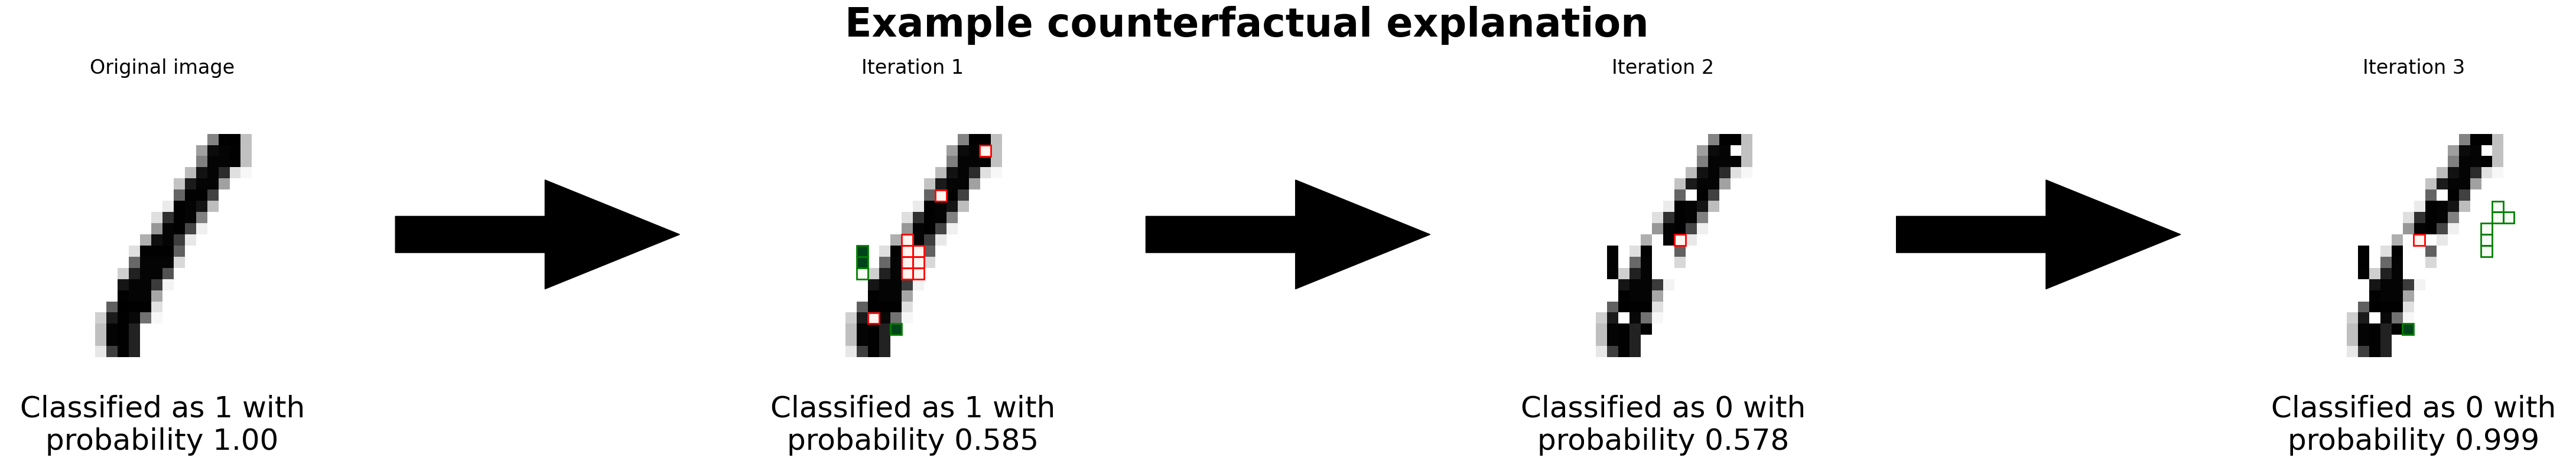

In [31]:
n = len(results)
subplots = 2 * n + 1
res = 8
fig, axs = plt.subplots(1, subplots, figsize=(res * subplots, res))
plt.suptitle("Example counterfactual explanation\n\n", weight="bold", fontsize=48)

initial_classification = results[0][1].class_prediction_function(
    pd.DataFrame(np.array(df.iloc[1]).astype(np.float32)[:-1]).T
)

axs[0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0].set_title("Original image", fontsize=24)
axs[0].set_xlabel(
    f"Classified as {initial_classification} with\nprobability {results[0][1].probability_prediction_function(pd.DataFrame(np.array(df.iloc[1]).astype(np.float32)[:-1]).T).max():.2f}",
    fontsize=36,
)

axs[0].set_xticks([])
axs[0].set_yticks([])
for spine in axs[0].spines:
    axs[0].spines[spine].set_visible(False)

working_new = df.iloc[1]
for i in range(1, subplots - 1, 2):
    plot_arrow(axs[i])
    working_new = plot_with_changes_highlighted(
        axs[i + 1],
        working_new,
        results[i // 2],
        initial_classification=initial_classification,
    )
    axs[i + 1].set_title(f"Iteration {i//2 + 1}", fontsize=24)
    for ax in [axs[i], axs[i + 1]]:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)

plt.savefig("../../figures/mnist_counterfactual_example.eps", bbox_inches="tight")
plt.savefig("../../figures/mnist_counterfactual_example.png", bbox_inches="tight")

In [32]:
overall_result = results[-1]

In [33]:
initial_point = df.iloc[1][:-1]
initial_classification = int(
    results[0][1].class_prediction_function(pd.DataFrame(initial_point).T)
)
working_point = initial_point.copy()
probabilities = [
    results[0][1].probability_prediction_function(pd.DataFrame(initial_point).T)[:, 1]
]
for feature in overall_result[0]:
    sve = SingleVariableExplainer(
        pipeline_with_reshape,
        "target",
        feature,
        working_point,
        training_dataset=df,
        regressor="linear",
        bounding_method="quantile",
        class_prediction_function=lambda x: pipeline_with_reshape.predict(x).argmax(),
        probability_prediction_function=lambda x: pipeline_with_reshape.predict(
            x
        ).reshape(-1, 2),
    )
    working_point[feature] = sve.get_arg_extrema(
        initial_classification=initial_classification
    )
    probabilities.append(
        results[0][1].probability_prediction_function(pd.DataFrame(working_point).T)[
            :, 1
        ]
    )

probabilities = [(1 - x[0]) for x in probabilities]
step_time = pd.DataFrame(overall_result[-1]).diff().values.flatten()
scores = overall_result[3]

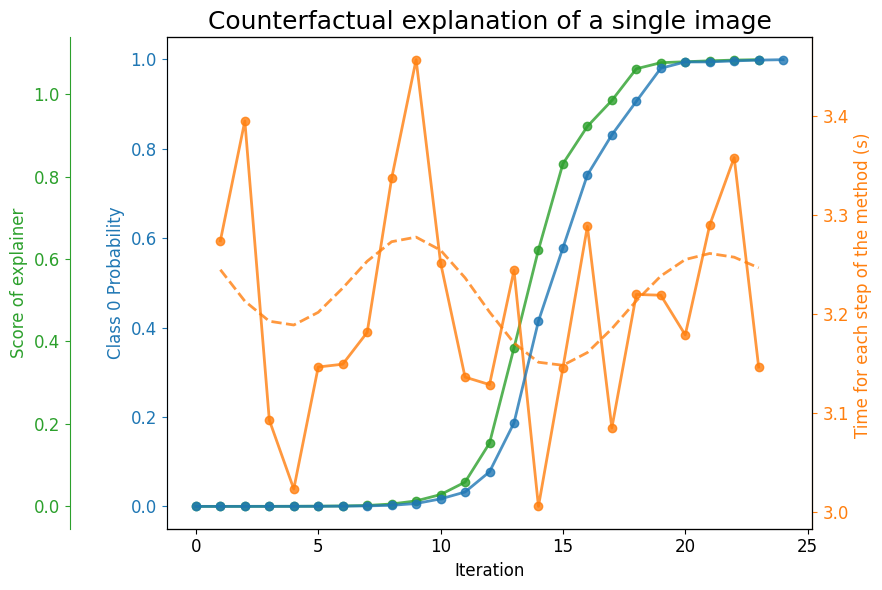

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(probabilities, "o-", linewidth=2, markersize=6, color="C0", alpha=0.8)

twin_ax = ax.twinx()
twin_ax.plot(step_time, "o-", linewidth=2, markersize=6, color="C1", alpha=0.8)

twin_ax_2 = ax.twinx()
twin_ax_2.plot(scores, "o-", linewidth=2, markersize=6, color="C2", alpha=0.8)

twin_ax_2.spines["left"].set_position(("axes", -0.15))
twin_ax_2.spines["left"].set_visible(True)

twin_ax_2.yaxis.set_label_position("left")
twin_ax_2.yaxis.set_ticks_position("left")

ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Class 0 Probability", fontsize=12)
twin_ax.set_ylabel("Time for each step of the method (s) ", fontsize=12)
twin_ax_2.set_ylabel("Score of explainer", fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=12)
twin_ax.tick_params(axis="both", which="major", labelsize=12)
twin_ax_2.tick_params(axis="both", which="major", labelsize=12)

fit_train_x = np.arange(len(step_time[1:]))
fit_train_y = step_time[1:]

gpr = SVR()
gpr.fit(fit_train_x.reshape(-1, 1), fit_train_y)
gpr_y_pred = gpr.predict(fit_train_x.reshape(-1, 1))

twin_ax.plot(fit_train_x + 1, gpr_y_pred, "--", linewidth=2, color="C1", alpha=0.8)

twin_ax.spines["left"].set_color("C0")
twin_ax.spines["right"].set_color("C1")
ax.yaxis.label.set_color("C0")
ax.tick_params(axis="y", colors="C0")
twin_ax.yaxis.label.set_color("C1")
twin_ax.tick_params(axis="y", colors="C1")
twin_ax_2.spines["left"].set_color("C2")
twin_ax_2.yaxis.label.set_color("C2")
twin_ax_2.tick_params(axis="y", colors="C2")

ax.set_zorder(twin_ax_2.get_zorder() + 2)
twin_ax.set_zorder(twin_ax_2.get_zorder() + 1)
ax.set_facecolor("none")

ax.set_title("Counterfactual explanation of a single image", fontsize=18)
plt.tight_layout()

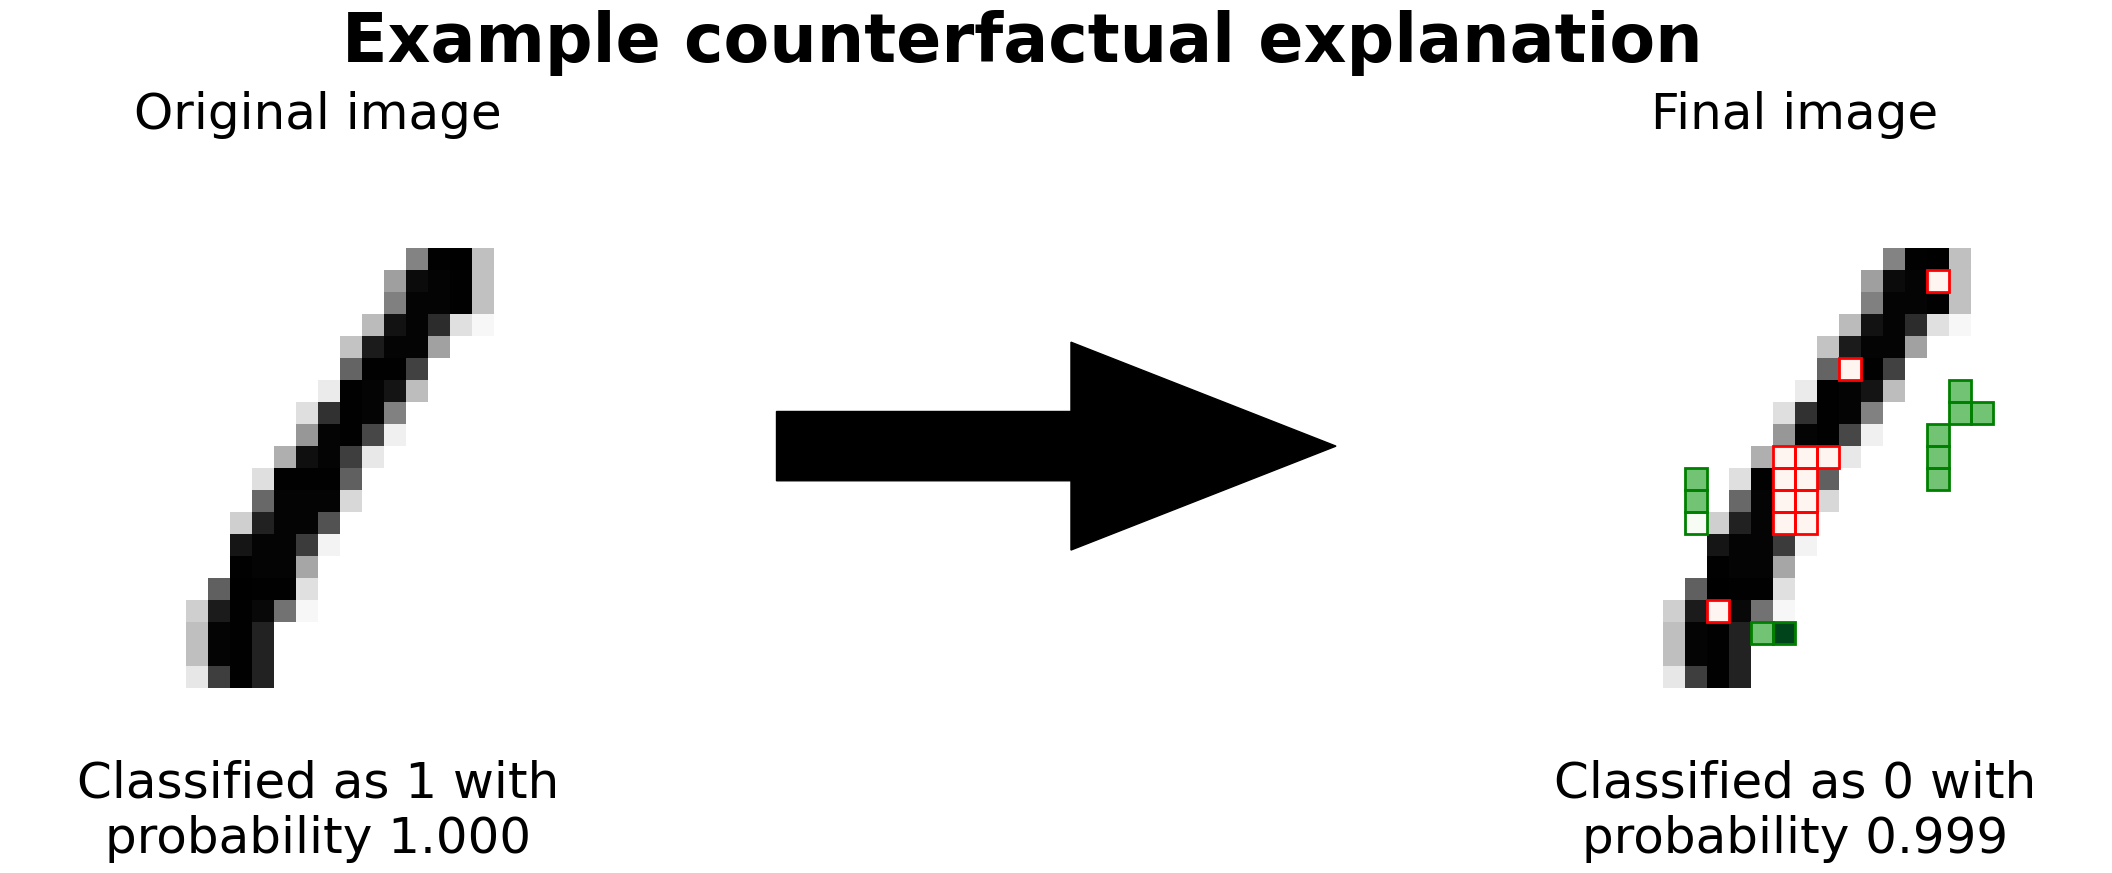

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax[0].imshow(
    np.array(df.iloc[1][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
ax[0].set_title("Original image", fontsize=36)
ax[0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[1][:-1]).reshape(-1, 2).max():.3f}",
    fontsize=36,
)

plot_arrow(ax[1])
_ = plot_with_changes_highlighted(
    ax[2],
    df.iloc[1],
    overall_result,
    initial_classification=pipeline_with_reshape.predict(df.iloc[1][:-1]).argmax(),
)
ax[2].set_title("Final image", fontsize=36)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines:
        a.spines[spine].set_visible(False)

plt.suptitle("Example counterfactual explanation\n\n", weight="bold", fontsize=48)

plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.eps", bbox_inches="tight"
)
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.png", bbox_inches="tight"
)

## Novel Counterfactuals using Gaussian Scoring Function

In [60]:
scores = gaussian_filter(
    ((df.iloc[2].values[:-1].astype(float).reshape(28, 28)) + 0.5), sigma=5
).reshape(784)
dict_scores = {x: y for x, y in zip(df.columns[:-1], scores) if y > 0.05}

In [62]:
explainer_scoring = Explainer(
    pipeline_with_reshape,
    df,
    "target",
    regressor="linear",
    bounding_method="minmax",
    changeability_scores=dict_scores,
    override_variable_bounds=(-0.5, 0.5),
    probability_prediction_function=lambda x: pipeline_with_reshape.predict(x).reshape(
        -1, 2
    ),
    class_prediction_function=lambda x: pipeline_with_reshape.predict(x).argmax(),
)

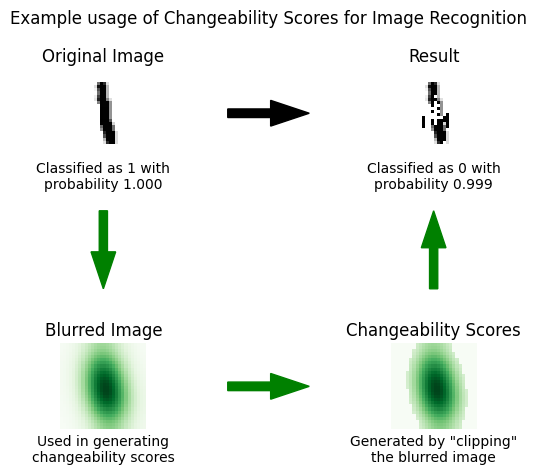

In [73]:
fig, axs = plt.subplots(3, 3)
plt.suptitle("Example usage of Changeability Scores for Image Recognition")

# Initial Image
axs[0, 0].imshow(
    np.array(df.iloc[2][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
axs[0, 0].set_title("Original Image")
axs[0, 0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[2][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[2][:-1]).reshape(-1, 2).max():.3f}"
)

# Blur Image
blurred = gaussian_filter(
    (np.array(df.iloc[2][:-1]).astype(np.float32).reshape(28, 28) + 0.5),
    sigma=5,
)
axs[2, 0].imshow(blurred, cmap="Greens")
axs[2, 0].set_title("Blurred Image")
axs[2, 0].set_xlabel("Used in generating\nchangeability scores")

# Changeability Scores
blurred[blurred <= 0.05] = 0
axs[2, 2].imshow(blurred, cmap="Greens")
axs[2, 2].set_title("Changeability Scores")
axs[2, 2].set_xlabel('Generated by "clipping"\nthe blurred image')

# Result
final = result_scoring[1].explanation_point
final[result_scoring[1].explainable_variable] = result_scoring[1].get_arg_extrema()
axs[0, 2].imshow(np.array(final[:-1]).astype(np.float32).reshape(28, 28), cmap="binary")
axs[0, 2].set_title("Result")
axs[0, 2].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(final[:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(final[:-1]).reshape(-1, 2).max():.3f}"
)

axs[0, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="k")
axs[0, 1].set_ylim([0, 1])

axs[2, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color="green")
axs[2, 1].set_ylim([0, 1])

axs[1, 0].arrow(x=0.5, y=0.75, dx=0, dy=-0.5, width=0.1, color="green")
axs[1, 0].set_xlim([0, 1])

axs[1, 2].arrow(x=0.5, y=0.25, dx=0, dy=0.5, width=0.1, color="green")
axs[1, 2].set_xlim([0, 1])

for ax_t in axs:
    for ax in ax_t:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_aspect("equal")

plt.tight_layout()
# fig.subplots_adjust(top=1.5)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)

plt.savefig("../../figures/mnist_changeability_example.eps", bbox_inches="tight")
plt.show()

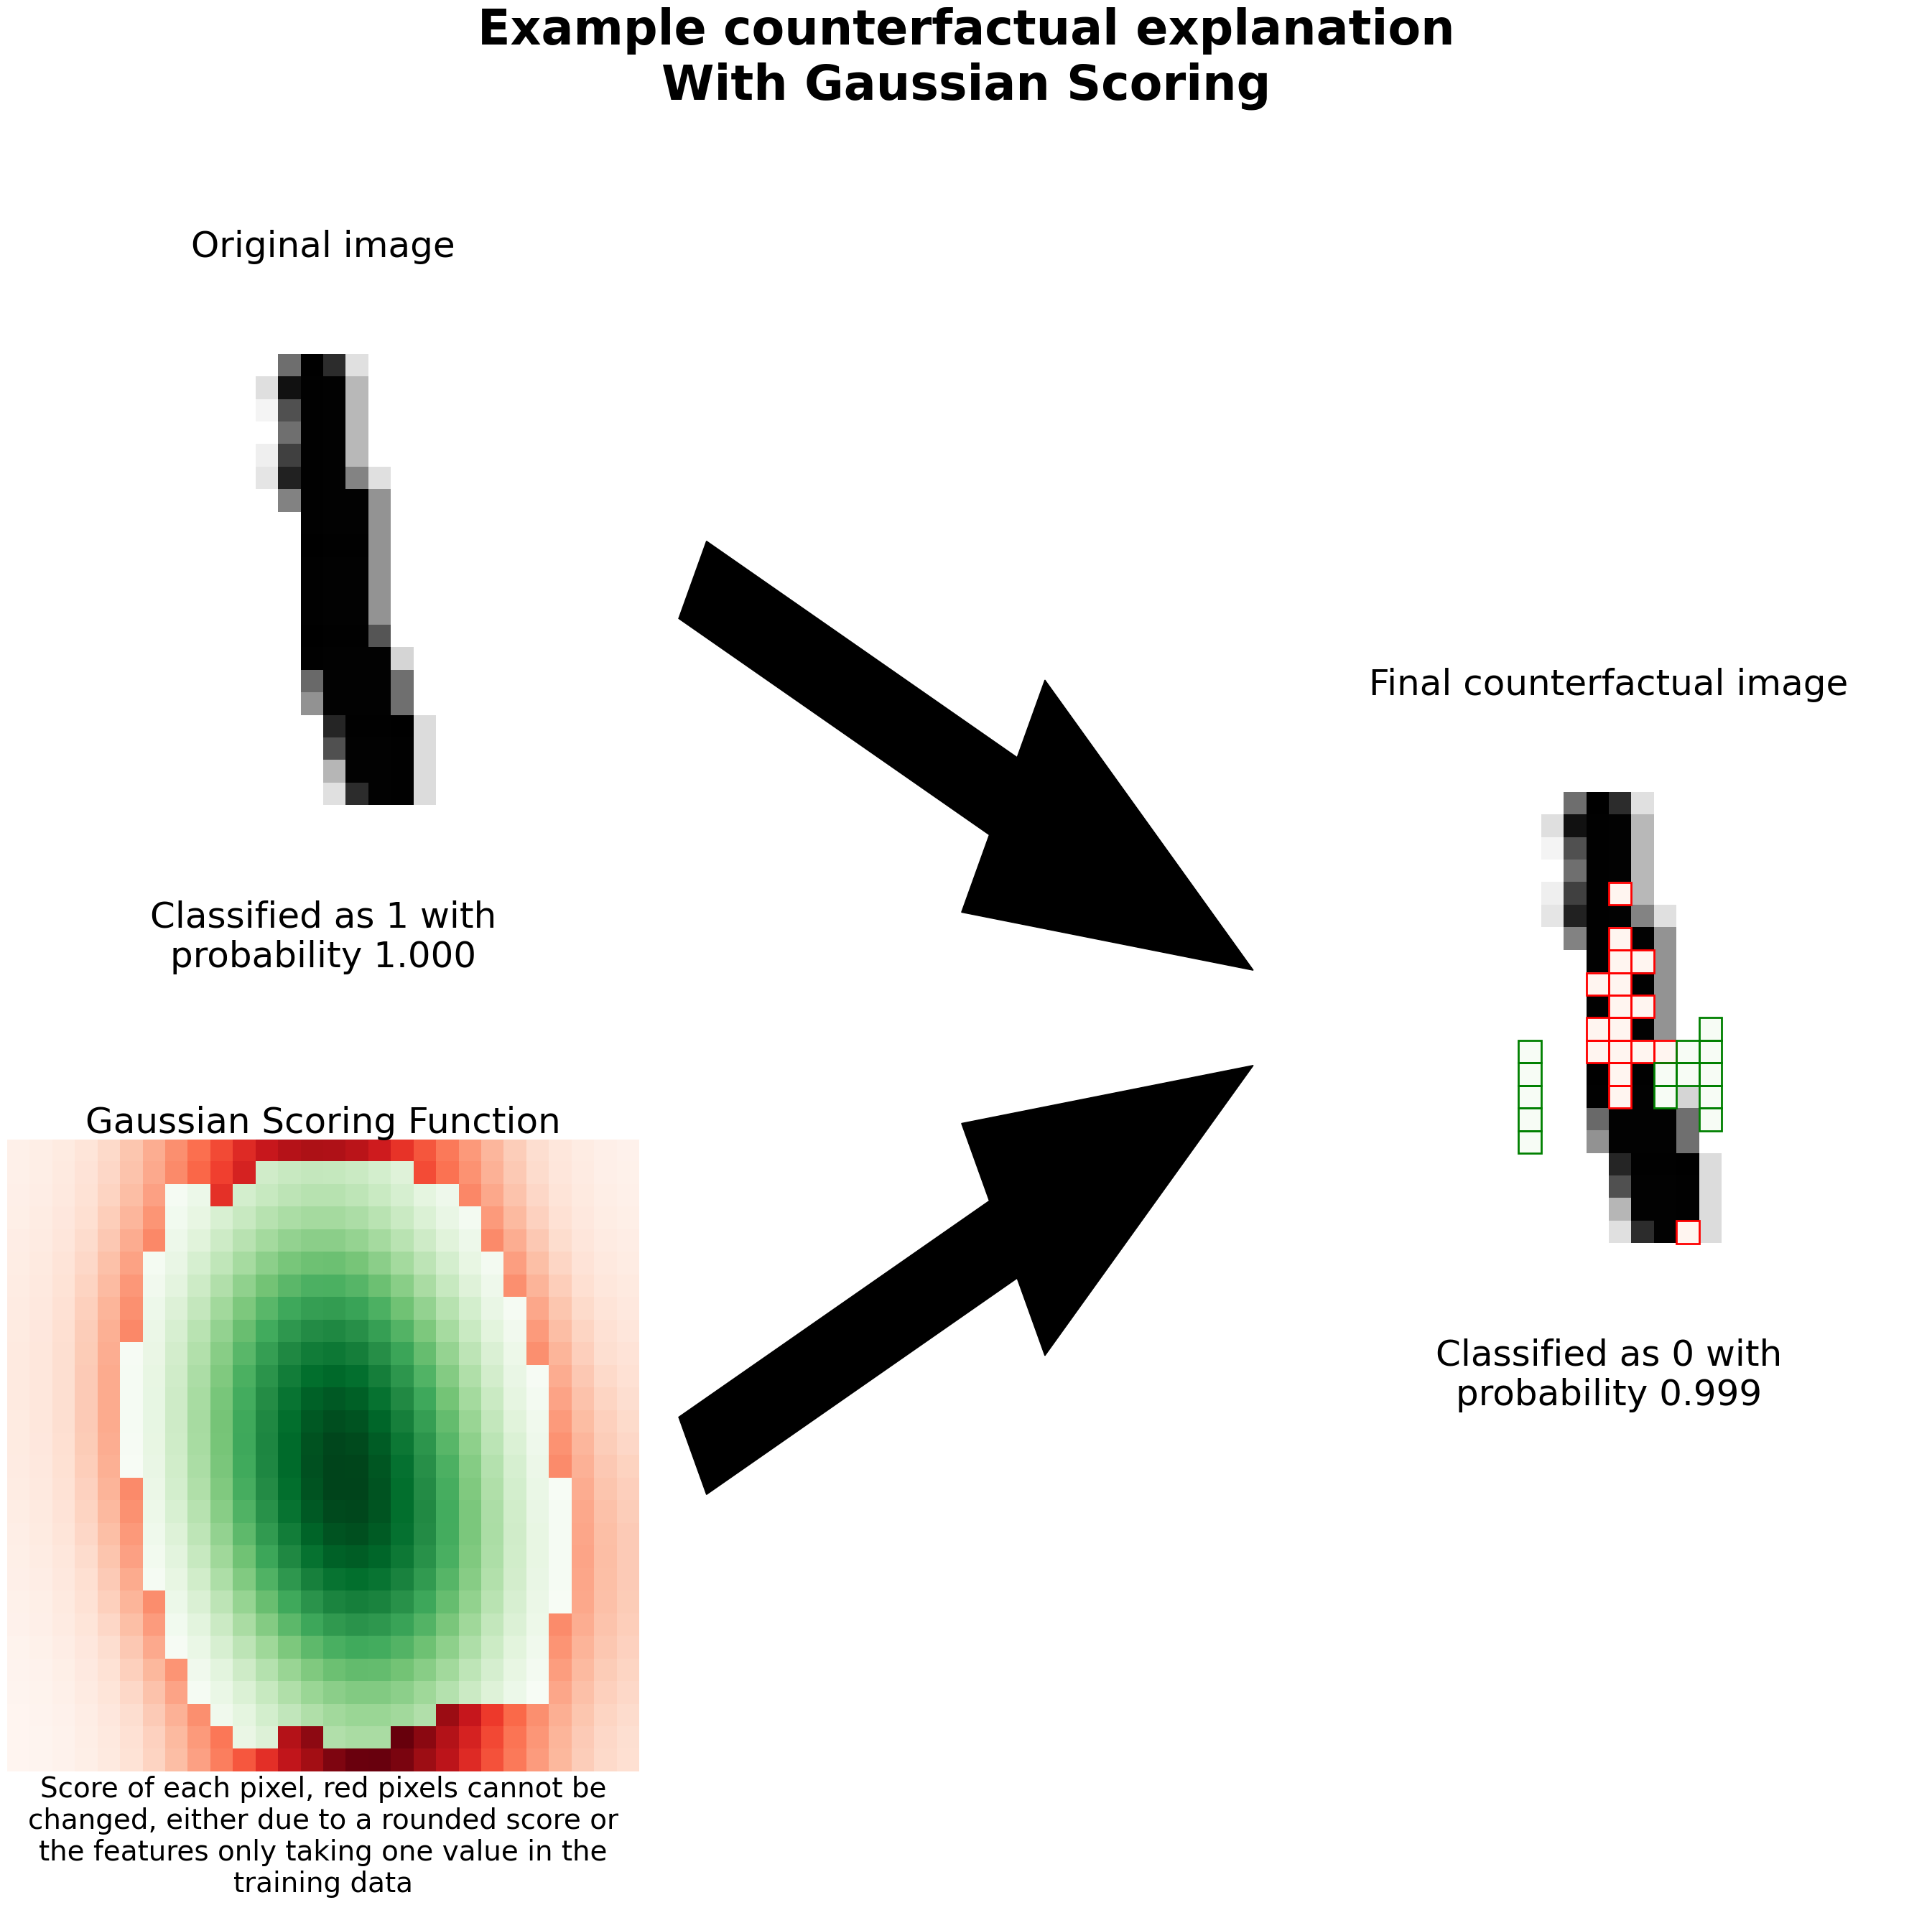

In [82]:
fig, ax = plt.subplots(2, 3, figsize=(27, 27))
ax[0, 0].imshow(
    np.array(df.iloc[2][:-1]).astype(np.float32).reshape(28, 28),
    cmap="binary",
)
ax[0, 0].set_title("Original image", fontsize=36)
ax[0, 0].set_xlabel(
    f"Classified as {pipeline_with_reshape.predict(df.iloc[2][:-1]).argmax()} with\nprobability {pipeline_with_reshape.predict(df.iloc[2][:-1]).reshape(-1, 2).max():.3f}",
    fontsize=36,
)

blurred = gaussian_filter(
    np.array(df.iloc[2][:-1]).astype(np.float32).reshape(28, 28) + 0.5,
    sigma=5,
)

red_blurred = blurred.copy()
blurred[blurred <= 0.05] = np.nan
blurred[
    ((df.values.astype(float).max(axis=0) - df.values.astype(float).min(axis=0)) == 0)[
        :-1
    ].reshape(28, 28)
] = np.nan

red_blurred[
    ((df.values.astype(float).max(axis=0) - df.values.astype(float).min(axis=0)) != 0)[
        :-1
    ].reshape(28, 28)
    & (blurred > 0.05)
] = np.nan

ax[1, 0].imshow(blurred, cmap="Greens")
ax[1, 0].imshow(red_blurred, cmap="Reds")
ax[1, 0].set_title("Gaussian Scoring Function", fontsize=36)
ax[1, 0].set_xlabel(
    "Score of each pixel, red pixels cannot be\nchanged, either due to a rounded score or\nthe features only taking one value in the\ntraining data",
    fontsize=28,
)

gs = ax[1, 2].get_gridspec()
for a in ax[:, -1]:
    a.remove()
axbig = fig.add_subplot(gs[:, -1])

ax[1, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=0.25, width=0.1, color="k")
ax[1, 1].set_ylim([0, 1])
ax[0, 1].arrow(x=0.25, y=0.5, dx=0.5, dy=-0.25, width=0.1, color="k")
ax[0, 1].set_ylim([0, 1])
_ = plot_with_changes_highlighted(
    axbig,
    df.iloc[2],
    result_scoring,
    initial_classification=pipeline_with_reshape.predict(df.iloc[2][:-1]).argmax(),
)
axbig.set_title("Final counterfactual image", fontsize=36)

for b in ax:
    for a in b:
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines:
            a.spines[spine].set_visible(False)
for a in [axbig]:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines:
        a.spines[spine].set_visible(False)


plt.suptitle(
    "Example counterfactual explanation\nWith Gaussian Scoring\n",
    weight="bold",
    fontsize=48,
)
plt.tight_layout()
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.eps", bbox_inches="tight"
)
plt.savefig(
    "../../figures/overall_mnist_counterfactual_example.png", bbox_inches="tight"
)

## SHAP Explanations

In [83]:
shap_explainer = shap.explainers.DeepExplainer(cnn, shap.sample(x_train, 1000))

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [84]:
shap_explanation = shap_explainer.shap_values(x_train[2].reshape(1, 28, 28, 1))

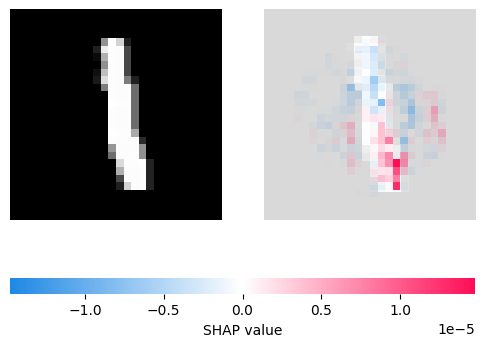

In [85]:
shap.image_plot(shap_explanation, x_train[2].reshape(1, 28, 28))